In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam as Adam
from tensorflow.keras.optimizers import SGD as SGD
from tensorflow.keras.optimizers import RMSprop as RMSprop
from tensorflow.keras.optimizers import Adagrad as Adagrad
from tensorflow.keras.optimizers import Adadelta as Adadelta
from tensorflow.keras.optimizers import Adamax as Adamax
from tensorflow.keras.optimizers import Nadam as Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import shutil
import tensorflow_ranking as tfr
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

2022-08-18 06:36:04.845292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/lunet/conm/.conda/envs/stenosispyv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(device_lib.list_local_devices())
# check available GPU with tensorflow
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13258164964381394115
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10507766976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17200872725404378085
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


2022-08-18 06:36:20.133024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 06:36:20.152640: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-18 06:36:20.155005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-18 06:36:20.475663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 06:36:20.477306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [3]:
train_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/train/stenosis'

test_path = '/home/lunet/conm/Desktop/Stenosis-Project/test_images'

val_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/val/stenosis'

train_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/train/stenosis'

val_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/val/stenosis'

27.678970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 06:36:27.680551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 06:36:27.682009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 06:36:27.683343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/device:GPU:0 with 10020 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5)


In [4]:
# Read train_labels.csv
train_labels_csv = pd.read_csv('train_labels.csv')
train_labels_csv_3 = pd.read_csv('train_labels_3.csv')
len(train_labels_csv_3)

5993

In [5]:
test_labels_csv = pd.read_csv('test_labels.csv')

In [6]:
val_labels_csv = pd.read_csv('val_labels.csv')
val_labels_csv_2 = pd.read_csv('val_labels_2.csv')
len(val_labels_csv_2)

1499

In [7]:
train_images = []
train_targets = []

In [8]:
val_images = []
val_targets = []

In [9]:
test_images = []
test_targets = []

In [10]:
for index, row in train_labels_csv_3.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(train_path2,filename))
    pic = cv2.resize(pic, (400, 400))
    # pic_arr = keras.preprocessing.image.img_to_array(pic)

    train_images.append(pic)
    train_targets.append((xmin, ymin, xmax, ymax))

In [11]:
for index, row in val_labels_csv_2.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(val_path2,filename))
    pic = cv2.resize(pic, (400, 400))
    # pic_arr = keras.preprocessing.image.img_to_array(pic)

    val_images.append(pic)
    val_targets.append((xmin, ymin, xmax, ymax))

In [12]:
for index, row in test_labels_csv.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(test_path,filename))
    pic = cv2.resize(pic, (400, 400))
    # pic_arr = keras.preprocessing.image.img_to_array(pic)

    test_images.append(pic)
    test_targets.append((xmin, ymin, xmax, ymax))

In [13]:
train_images = np.asarray(train_images).astype('float32')
train_targets = np.asarray(train_targets).astype('float32')

In [14]:
val_images = np.asarray(val_images).astype('float32')
val_targets = np.asarray(val_targets).astype('float32')

In [15]:
test_images = np.asarray(test_images).astype('float32')
test_targets = np.asarray(test_targets).astype('float32')

In [16]:
test_images.shape

(833, 400, 400, 3)

In [17]:
val_images.shape

(1499, 400, 400, 3)

In [18]:
train_images.shape

(5993, 400, 400, 3)

In [19]:
# Normalize targets
train_targets /= 256
val_targets /= 256

# Normalize images
train_images /= 255
val_images /= 255

# Normalize test images
test_images /= 255
test_targets /= 256

In [20]:
dataGenerator = ImageDataGenerator(rotation_range=0, 
                                   zoom_range=0, 
                                   width_shift_range=0, 
                                   height_shift_range=0, 
                                   horizontal_flip=False,
                                   vertical_flip=False,)

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [22]:
# Create a new model for object detection and transfer learning
initializer = tf.keras.initializers.HeUniform()
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(350, 350, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam', metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])

2022-08-14 01:45:05.518390: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 01:45:05.735911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 01:45:05.737386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-14 01:45:06.377753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-14 01:45:06.509686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 01:45:06.520983: I tensorflow/stream_executor/plat

In [24]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)
# Model training
# Add confidence threshold to filter out false positives
# model.fit(train_images, train_targets, validation_data=(val_images, val_targets), epochs=100, batch_size=32, callbacks=[es])


# confidence_threshold = 0.5

history = model.fit(dataGenerator.flow(train_images, train_targets, batch_size=8),
                            validation_data=(val_images, val_targets), 
                            epochs=150, callbacks=es, verbose=1)

2022-08-14 01:45:09.437649: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-14 01:45:09.488425: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-14 01:45:10.996149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 01:45:12.430962: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


843/843 [==============================] - 27s 22ms/step - loss: 1.0291 - mean_average_precision_metric: 0.6585 - val_loss: 0.2676 - val_mean_average_precision_metric: 0.6670
Epoch 2/150
843/843 [==============================] - 12s 15ms/step - loss: 0.2267 - mean_average_precision_metric: 0.7132 - val_loss: 0.1905 - val_mean_average_precision_metric: 0.7329
Epoch 3/150
843/843 [==============================] - 13s 15ms/step - loss: 0.1793 - mean_average_precision_metric: 0.7259 - val_loss: 0.1311 - val_mean_average_precision_metric: 0.7427
Epoch 4/150
843/843 [==============================] - 13s 15ms/step - loss: 0.1548 - mean_average_precision_metric: 0.7495 - val_loss: 0.1047 - val_mean_average_precision_metric: 0.7561
Epoch 5/150
843/843 [==============================] - 12s 15ms/step - loss: 0.1242 - mean_average_precision_metric: 0.7488 - val_loss: 0.0880 - val_mean_average_precision_metric: 0.7589
Epoch 6/150
843/843 [==============================] - 13s 15ms/step - loss: 

In [26]:
# Save model
model.save('model.h5')


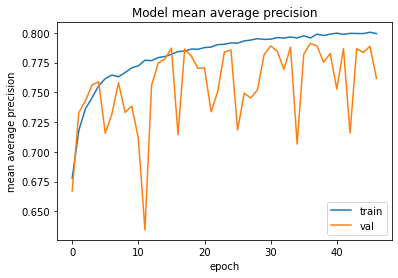

In [27]:
# Create line plot of mean average precision
import matplotlib.pyplot as plt
plt.plot(history.history['mean_average_precision_metric'])
plt.plot(history.history['val_mean_average_precision_metric'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
# Visualize the model prediction images with bounding box dimensions predicted by the model and ground truth bounding box dimensions
# Create a figure with subplots of the images and bounding box dimensions
import matplotlib.pyplot as plt
model.evaluate(test_images, test_targets, verbose=1)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    plt.xlabel('Stenosis')
plt.show()

In [25]:
initializer = tf.keras.initializers.HeUniform()

model_1 = Sequential()

model_1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model_1.add(RandomFlip(mode='horizontal_and_vertical', seed=None))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_1.add(Conv2D(32, (3, 3), activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (3, 3), activation='relu'))
# model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

# model_1.add(Conv2D(128, (3, 3), activation='relu'))
# model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_1.add(Flatten())
model_1.add(Dropout(0.35))
model_1.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model_1.add(Dropout(0.35))

model_1.add(Dense(4))

model_1.compile(loss='mse', optimizer='adam', metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 298, 298, 16)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
batch_normalization_17 (Batc (None, 147, 147, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 73, 73, 32)       

In [28]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

history_1 = model_1.fit(dataGenerator.flow(train_images, train_targets, batch_size=32),
                            validation_data=(val_images, val_targets),
                            epochs=150, callbacks=es, verbose=1)

2022-08-14 17:34:37.447914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-14 17:34:37.468424: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-14 17:34:38.373857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 17:34:38.478875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


210/211 [============================>.] - ETA: 0s - loss: 11.7244 - mean_average_precision_metric_4: 0.6034

2022-08-14 17:34:48.628115: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 810000000 exceeds 10% of free system memory.


211/211 [==============================] - 12s 48ms/step - loss: 11.6671 - mean_average_precision_metric_4: 0.6036 - val_loss: 2.9727 - val_mean_average_precision_metric_4: 0.5956
Epoch 2/150
211/211 [==============================] - 9s 44ms/step - loss: 2.6100 - mean_average_precision_metric_4: 0.6703 - val_loss: 1.8574 - val_mean_average_precision_metric_4: 0.6066
Epoch 3/150
211/211 [==============================] - 9s 44ms/step - loss: 1.6968 - mean_average_precision_metric_4: 0.6913 - val_loss: 1.1920 - val_mean_average_precision_metric_4: 0.7065
Epoch 4/150
211/211 [==============================] - 9s 44ms/step - loss: 1.2129 - mean_average_precision_metric_4: 0.7046 - val_loss: 0.8664 - val_mean_average_precision_metric_4: 0.7300
Epoch 5/150
211/211 [==============================] - 9s 44ms/step - loss: 0.9146 - mean_average_precision_metric_4: 0.7207 - val_loss: 0.6582 - val_mean_average_precision_metric_4: 0.7555
Epoch 6/150
211/211 [==============================] - 9s 44

In [35]:
model_1.evaluate(test_images, test_targets, verbose=1)

10/27 [==========>...................] - ETA: 0s - loss: 0.1312 - mean_average_precision_metric_4: 0.7933

2022-08-14 17:44:26.338302: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 899640000 exceeds 10% of free system memory.


27/27 [==============================] - 0s 15ms/step - loss: 0.1334 - mean_average_precision_metric_4: 0.7751


[0.13339519500732422, 0.7751099467277527]

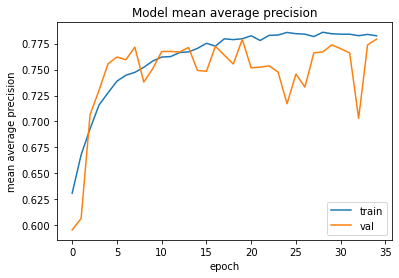

In [41]:
plt.plot(history_1.history['mean_average_precision_metric_4'])
plt.plot(history_1.history['val_mean_average_precision_metric_4'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [22]:
initializer = tf.keras.initializers.HeUniform()

model_2 = Sequential()

model_2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model_2.add(RandomFlip(mode='horizontal_and_vertical', seed=None))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
# model_1.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

# model_1.add(Conv2D(128, (3, 3), activation='relu'))
# model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dropout(0.35))
model_2.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model_2.add(Dropout(0.35))

model_2.add(Dense(4))

model_2.compile(loss='mse', optimizer='adam', metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
random_flip (RandomFlip)     (None, 298, 298, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 147, 147, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0

2022-08-14 19:44:57.825470: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 19:44:57.825588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 19:44:57.825883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-14 19:44:57.825911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-14 19:44:57.825926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 19:44:57.825936: I tensorflow/stream_executor/plat

In [23]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

history_2 = model_2.fit(dataGenerator.flow(train_images, train_targets, batch_size=64),
                            validation_data=(val_images, val_targets),
                            epochs=150, callbacks=es, verbose=1)

2022-08-14 19:44:58.850430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-14 19:44:58.868563: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-14 19:44:59.664440: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 19:44:59.777914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


106/106 [==============================] - ETA: 0s - loss: 46.2078 - mean_average_precision_metric: 0.6129

2022-08-14 19:45:09.952580: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 810000000 exceeds 10% of free system memory.


106/106 [==============================] - 12s 94ms/step - loss: 46.0347 - mean_average_precision_metric: 0.6131 - val_loss: 12.4521 - val_mean_average_precision_metric: 0.6414
Epoch 2/150
106/106 [==============================] - 9s 87ms/step - loss: 10.4708 - mean_average_precision_metric: 0.6504 - val_loss: 6.2104 - val_mean_average_precision_metric: 0.5563
Epoch 3/150
106/106 [==============================] - 9s 87ms/step - loss: 5.3712 - mean_average_precision_metric: 0.6855 - val_loss: 3.4264 - val_mean_average_precision_metric: 0.7009
Epoch 4/150
106/106 [==============================] - 9s 88ms/step - loss: 2.9861 - mean_average_precision_metric: 0.7088 - val_loss: 1.9981 - val_mean_average_precision_metric: 0.6831
Epoch 5/150
106/106 [==============================] - 9s 88ms/step - loss: 1.7349 - mean_average_precision_metric: 0.7126 - val_loss: 1.2208 - val_mean_average_precision_metric: 0.7260
Epoch 6/150
106/106 [==============================] - 9s 88ms/step - loss: 1.

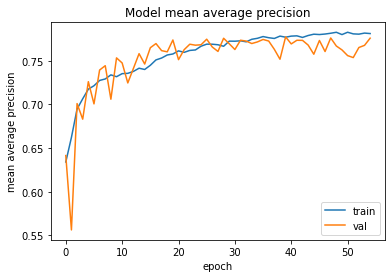

In [24]:
plt.plot(history_2.history['mean_average_precision_metric'])
plt.plot(history_2.history['val_mean_average_precision_metric'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [23]:
# initializer = tf.keras.initializers.HeUniform()
model_3 = Sequential()

model_3.add(Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model_3.add(RandomFlip(mode='horizontal_and_vertical', seed=None))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_3.add(Conv2D(128, (3, 3), activation='relu'))
# model_1.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

# model_1.add(Conv2D(128, (3, 3), activation='relu'))
# model_1.add(MaxPool2D(pool_size=(2, 2)))
# model_1.add(Dropout(0.25))

model_3.add(Flatten())
# model_3.add(Dropout(0.35))
model_3.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Dropout(0.35))

model_3.add(Dense(4))

model_3.compile(loss='mse', optimizer='adam', metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 298, 298, 16)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 147, 147, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 73, 73, 32)       

In [26]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

history_3 = model_3.fit(dataGenerator.flow(train_images, train_targets, batch_size=64),
                            validation_data=(val_images, val_targets),
                            epochs=150, callbacks=es, verbose=1)

2022-08-14 22:17:06.674252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-14 22:17:06.692300: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-14 22:17:07.599316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-14 22:17:07.717533: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


106/106 [==============================] - ETA: 0s - loss: 20.2258 - mean_average_precision_metric_2: 0.5798

2022-08-14 22:17:18.858767: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 810000000 exceeds 10% of free system memory.


106/106 [==============================] - 13s 102ms/step - loss: 20.1146 - mean_average_precision_metric_2: 0.5799 - val_loss: 3.5574 - val_mean_average_precision_metric_2: 0.5931
Epoch 2/150
106/106 [==============================] - 10s 95ms/step - loss: 3.3383 - mean_average_precision_metric_2: 0.6456 - val_loss: 2.8773 - val_mean_average_precision_metric_2: 0.6014
Epoch 3/150
106/106 [==============================] - 10s 95ms/step - loss: 2.5378 - mean_average_precision_metric_2: 0.6693 - val_loss: 2.2343 - val_mean_average_precision_metric_2: 0.6617
Epoch 4/150
106/106 [==============================] - 10s 95ms/step - loss: 2.0864 - mean_average_precision_metric_2: 0.6704 - val_loss: 1.9397 - val_mean_average_precision_metric_2: 0.6750
Epoch 5/150
106/106 [==============================] - 10s 93ms/step - loss: 1.7801 - mean_average_precision_metric_2: 0.6890 - val_loss: 1.5686 - val_mean_average_precision_metric_2: 0.6820
Epoch 6/150
106/106 [==============================] - 

In [96]:
plt.plot(history_3.history['mean_average_precision_metric_2'])
plt.plot(history_3.history['val_mean_average_precision_metric_2'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

NameError: name 'history_3' is not defined

In [22]:
model_4 = Sequential()

model_4.add(Conv2D(16, (3, 3), input_shape=(400, 400, 3,), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
# model_4.add(RandomFlip(mode='horizontal_and_vertical', seed=None))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# model_4.add(Dropout(0.35))

model_4.add(Conv2D(32, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# model_4.add(Dropout(0.35))

model_4.add(Conv2D(64, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# model_4.add(Dropout(0.35))

model_4.add(Conv2D(64, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Conv2D(128, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Conv2D(128, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Conv2D(128, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Conv2D(128, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Conv2D(128, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Conv2D(128, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Conv2D(128, (3, 3), padding='same'))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model_4.add(Flatten())
# model_4.add(GlobalAveragePooling2D())
model_4.add(Dropout(0.35))
model_4.add(Dense(512, kernel_regularizer=regularizers.l2(0.1)))
model_4.add(LeakyReLU(alpha=0.1))
model_4.add(Dropout(0.35))

model_4.add(Dense(4))

model_4.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])

model_4.summary()

2022-08-18 06:38:49.896288: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-18 06:38:50.055736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 06:38:50.056165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-18 06:38:50.531044: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-18 06:38:50.638677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-18 06:38:50.657515: I tensorflow/stream_executor/plat

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 400, 400, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 400, 400, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 400, 400, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 200, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 32)      1

In [23]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

history_4 = model_4.fit(dataGenerator.flow(train_images, train_targets, batch_size=16),
                            validation_data=(val_images, val_targets),
                            epochs=250, callbacks=es, verbose=1, shuffle=True)

2022-08-18 06:39:33.022335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-18 06:39:33.076467: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-18 06:39:35.058201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-18 06:39:36.651194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


374/375 [============================>.] - ETA: 0s - loss: 16.7564 - mean_average_precision_metric: 0.6514

2022-08-18 06:39:59.635776: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2878080000 exceeds 10% of free system memory.


375/375 [==============================] - 29s 54ms/step - loss: 16.7349 - mean_average_precision_metric: 0.6516 - val_loss: 7.1155 - val_mean_average_precision_metric: 0.6716
Epoch 2/250
375/375 [==============================] - 14s 36ms/step - loss: 4.9630 - mean_average_precision_metric: 0.7454 - val_loss: 1.7613 - val_mean_average_precision_metric: 0.7839
Epoch 3/250
375/375 [==============================] - 14s 36ms/step - loss: 1.3017 - mean_average_precision_metric: 0.7775 - val_loss: 0.3933 - val_mean_average_precision_metric: 0.7898
Epoch 4/250
375/375 [==============================] - 14s 36ms/step - loss: 0.3108 - mean_average_precision_metric: 0.7827 - val_loss: 0.0911 - val_mean_average_precision_metric: 0.7943
Epoch 5/250
375/375 [==============================] - 14s 36ms/step - loss: 0.0922 - mean_average_precision_metric: 0.7877 - val_loss: 0.0539 - val_mean_average_precision_metric: 0.7931
Epoch 6/250
375/375 [==============================] - 14s 36ms/step - loss:

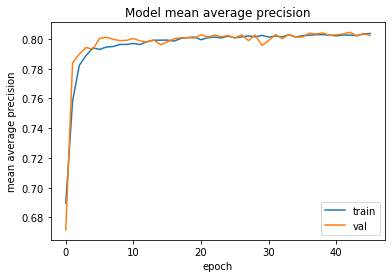

In [24]:
plt.plot(history_4.history['mean_average_precision_metric'])
plt.plot(history_4.history['val_mean_average_precision_metric'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [25]:
model_4.evaluate(test_images, test_targets, verbose=1, batch_size=64)

2022-08-18 06:50:48.301554: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1599360000 exceeds 10% of free system memory.
2022-08-18 06:50:48.565989: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-08-18 06:50:48.566045: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-08-18 06:50:48.566048: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.


14/14 [==============================] - 1s 62ms/step - loss: 0.0104 - mean_average_precision_metric: 0.7965


[0.01044217124581337, 0.7965186238288879]

In [26]:
model_4.save('model_4.h5')

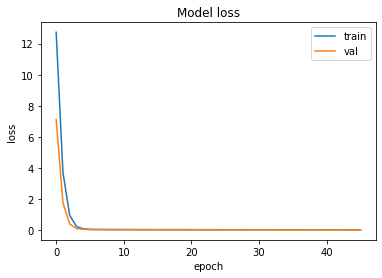

In [27]:
# Plot the training and validation loss of the model
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()